# Multimedia Security and Privacy
## TP4 - Watermark Detection
### Genis Skura
#### 1. Watermark Embedding

We start by reading the original image (a *512x512* lena) and convert it to grayscale. This image will serve as the host where we are going to perform the watermarking

Image:  [[162 162 162 ... 170 155 128]
 [162 162 162 ... 170 155 128]
 [162 162 162 ... 170 155 128]
 ...
 [ 43  43  50 ... 104 100  98]
 [ 44  44  55 ... 104 105 108]
 [ 44  44  55 ... 104 105 108]]
Image Shape:  (512, 512)


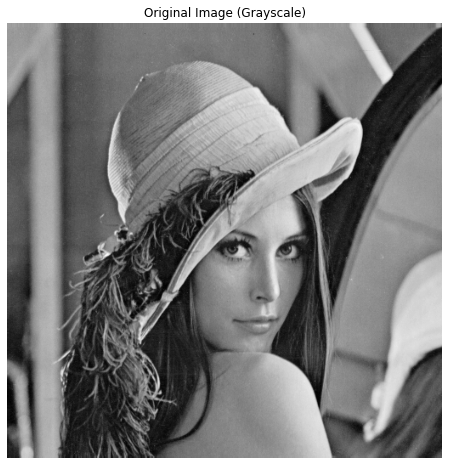

In [54]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

img = cv.cvtColor(cv.imread('lena.png'), cv.COLOR_BGR2GRAY)
print('Image: ', img)
print('Image Shape: ', img.shape)

plt.figure(figsize=(8, 8))
plt.title('Original Image (Grayscale)')
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()

The watermark is generated by randomly sampling from a matrix with the same size as the host image filled with uniformly distributed values ($\{-1, 1\}$ in our case). The density $\theta_N$ affects the size of the watermark.

[[ 1 -1 -1 ... -1  0 -1]
 [-1  0  0 ...  1 -1 -1]
 [ 1  0  0 ... -1 -1  0]
 ...
 [ 0  0  0 ... -1 -1  0]
 [ 1  0 -1 ...  1  1  0]
 [ 0 -1  0 ...  1 -1  0]]


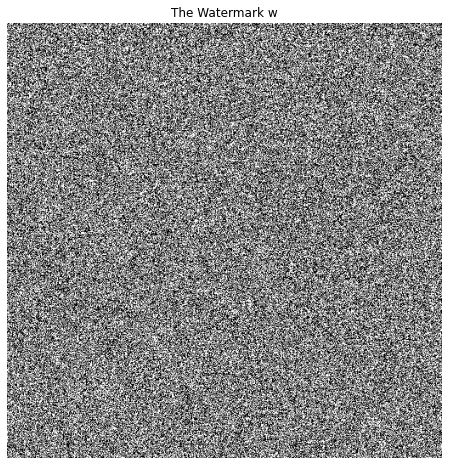

In [55]:
def generate_watermark(im, low_val, high_val, density):
    w_matrix = np.random.uniform(low_val, high_val, (im.shape))  # uniformly distributed values from interval [-1, 1], the w matrix
    w_distribution = np.array([[low_val if x < 0 else high_val for x in y] for y in w_matrix]).reshape(im.shape) # Turn the matrix into equally distributed -1s and 1s
    w = (np.array([val if np.random.random()<density else 0 for val in w_distribution.flatten()])).reshape(im.shape[0], im.shape[1]) # Create the final watermark based on the given density 
    return w


density = 0.5
watermark = generate_watermark(img, -1, 1, density)
sample_size = int((watermark.shape[0] * watermark.shape[1]) * density) ## Length of the Watermark

plt.figure(figsize=(8, 8))
plt.title('The Watermark w')
plt.imshow(watermark, cmap = 'gray')
plt.axis('off')
plt.show()

Now that we've defined the watermark $w$, we add it to random positions of our host image (the number of positions defined by our watermark length $N = (N_1 \cdot N_2) \theta_N$ to then generate our watermarked image $y$. Additive White Gaussian Noise $z$ is generated ($\mu = 0, \sigma^2 = 1$) and added to this watermarked image to generate a sample of an attacked image $v$.

In [56]:
def additive_white_noise(image, variance):
    white_noise =  np.sqrt(variance) * np.random.randn(image.shape[0], image.shape[1]) + 0 # white noise is ok, mean = 0
    noizy_img = image + white_noise
    return noizy_img, white_noise  # np.clip and conversion to uint8 [0, 255]


y = img + watermark # Watermarked image (original image img + watermark w)
attacked_y, z = additive_white_noise(y, 1)  # Attacked Image v including the addition of noise z 

Plotting of the Original Image **x**, Watermarked Image **y**, and Attacked Image **v** side by side. 
PSNR calculations are in comparison with the original host image.

C:\Users\Genis\AppData\Local\Temp\ipykernel_18044\1214743551.py:10: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  ax[1].set_title('Watermarked Image y | PSNR: {}'.format(psnr(img, y)))
C:\Users\Genis\AppData\Local\Temp\ipykernel_18044\1214743551.py:14: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  ax[2].set_title('Attacked Watermarked Image v | PSNR: {}'.format(psnr(img, attacked_y)))


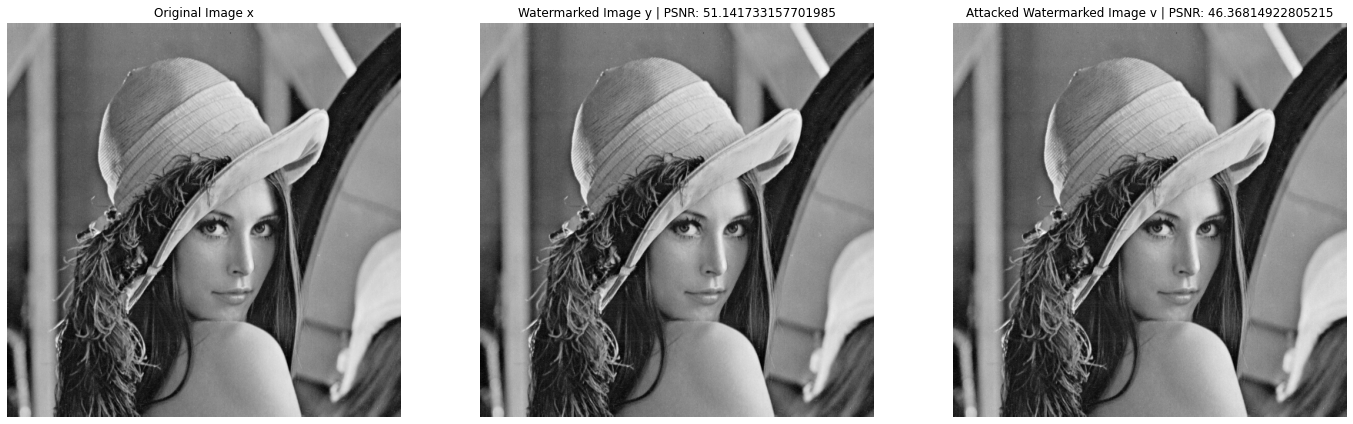

In [57]:
from skimage.metrics import peak_signal_noise_ratio as psnr

fig1, axes = plt.subplots(1, 3, figsize = (24, 8))
ax = axes.ravel() 
ax[0].imshow(img, cmap = 'gray')
ax[0].set_title('Original Image x')
ax[0].axis('off')

ax[1].imshow(y, cmap = 'gray')
ax[1].set_title('Watermarked Image y | PSNR: {}'.format(psnr(img, y)))
ax[1].axis('off')

ax[2].imshow(attacked_y, cmap = 'gray')
ax[2].set_title('Attacked Watermarked Image v | PSNR: {}'.format(psnr(img, attacked_y)))
ax[2].axis('off')
plt.show()

The only noticeable difference between the images compared to the original is the PSNR measurement. Apart from that we cannot notice any difference between the host image $x$, watermarked image $y$, and the attacked watermarked image $v$. How can we explain this? We could say that the watermarking is effective since it hasn't caused any difference to the image but in addition to that also the attack performed with the addition of noise $z$ could be seen as effective.

#### 2. Non-Blind Watermark Detection

In this second part of the TP we will assume the role of the attacker and attack the watermarked image given that we have knowledge of the original image. (*non-blind*) 

seems ok


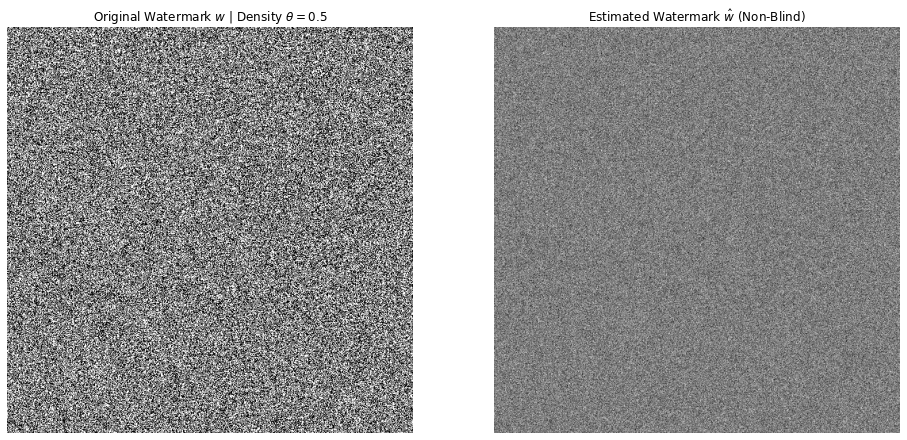

In [58]:
nb_estimated_watermark = attacked_y - img
if(z.all() == nb_estimated_watermark.all()):
    print('seems ok')

fig1, axes = plt.subplots(1, 2, figsize = (16, 8))
ax = axes.ravel() 
ax[0].imshow(watermark, cmap = 'gray')
ax[0].set_title(r'Original Watermark $w$ | Density $\theta = 0.5$')
ax[0].axis('off')

ax[1].imshow(nb_estimated_watermark, cmap = 'gray')
ax[1].set_title(r'Estimated Watermark $\hat{w}$ (Non-Blind)')
ax[1].axis('off')
plt.show()

*Linear Correlation between the original watermark and the estimated watermark extracted from the attacker as a statistical representation of the efficiency of his attack.*

In [62]:
def linear_correlation(original, estimated, n):
    return (np.sum(np.multiply(estimated, original))) / n

lin_corr = linear_correlation(watermark, nb_estimated_watermark, sample_size)
print('Non Blind Correlation: ', lin_corr)

Non Blind Correlation:  0.9975433343124193


We can see that we get a very high linear correlation value close to the max value of 1, meaning the non-blind estimated and original watermark are highly correlated to the point that they are almost the same. We could percieve this as the efficiency of the non-blind estimation.

#### 3. Blind Watermark Detection
The second method that a potential attacker can use to detect the watermark hidden in our image is based on the *Maximum Likelihood Estimate*. In this scenario, the attacker has access to only our marked image without prior knowledge of the original host image.

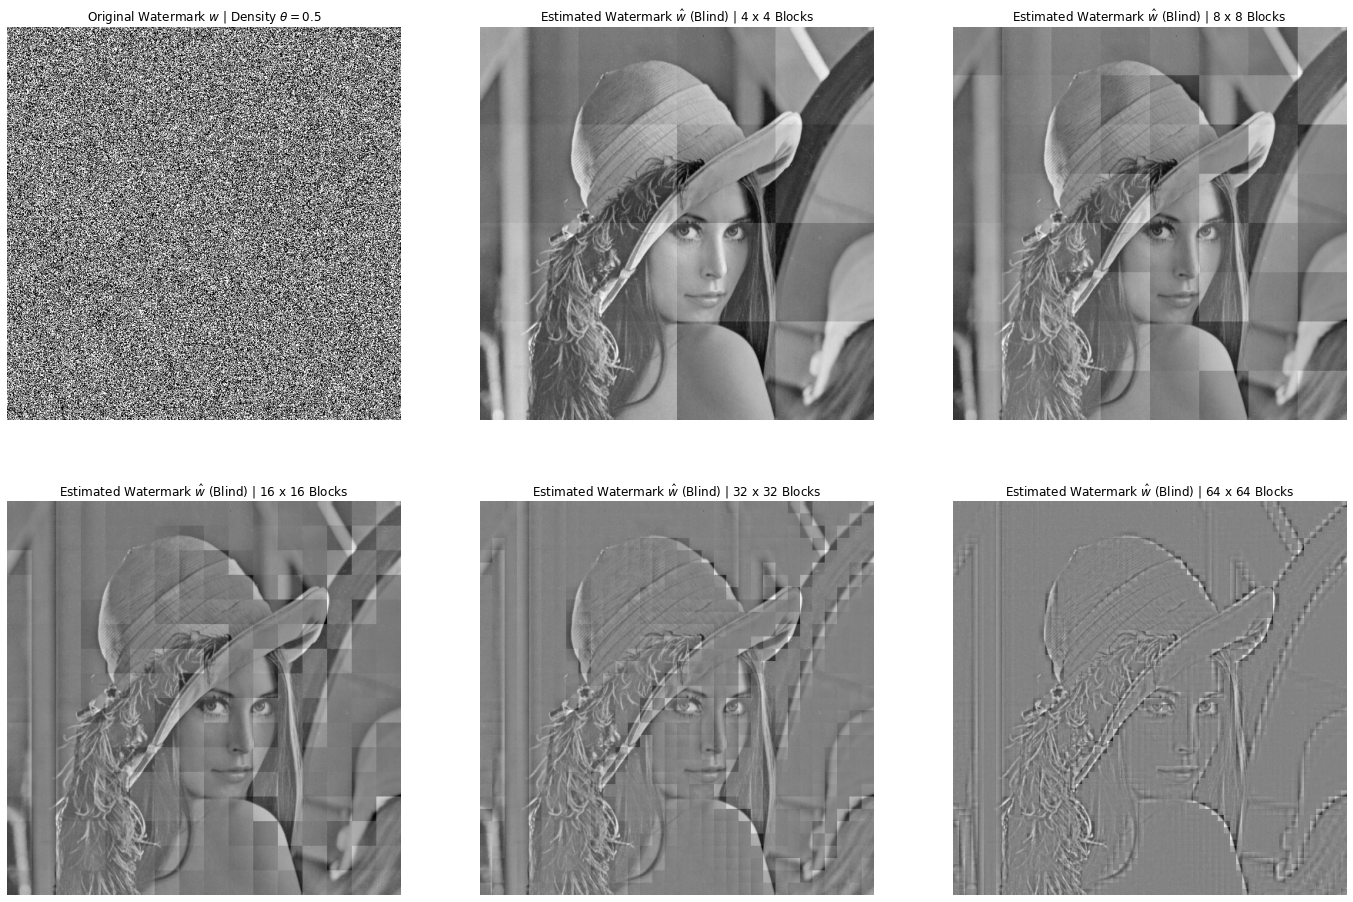

In [60]:
from skimage.util import view_as_blocks

# Method 1: Substract the local mean between blocks
def local_mean_blind(block_n, img):
    blind_estimation = np.copy(img)
    views = view_as_blocks(blind_estimation, block_shape=(int(img.shape[0] / block_n), int(img.shape[1] / block_n)))
    for i in range(block_n):
        for j in range(block_n):
            local_mean = np.mean(views[i][j])
            views[i][j] -= local_mean
    return blind_estimation


block_number = [4, 8, 16, 32, 64] # Try with different blocks

fig1, axes = plt.subplots(2, 3, figsize = (24, 16))
ax = axes.ravel() 
ax[0].imshow(watermark, cmap = 'gray')
ax[0].set_title(r'Original Watermark $w$ | Density $\theta = 0.5$')
ax[0].axis('off')

for i in range(1, len(ax)):
    blind_estimated_l = local_mean_blind(block_number[i - 1], attacked_y)
    ax[i].imshow(blind_estimated_l, cmap = 'gray')
    ax[i].set_title(r'Estimated Watermark $\hat{w}$ (Blind)' + ' | {} x {} Blocks'.format(block_number[i - 1], block_number[i - 1]))
    ax[i].axis('off')
plt.show()

In [77]:
# The Linear Correlation (32 x 32 blocks)
blind_estimated_l = local_mean_blind(32, attacked_y)
print('Blind Local Mean: ', linear_correlation(watermark, blind_estimated_l, sample_size))

Blind Local Mean:  0.9060767831083586


*Remarks*: From the two examples above we can say that the non-blind watermark estimation method done by the attacker has a higher chance of success since it gets very close to the original watermark. This is expected as he is assumed to also have the original image which he can leverage. 

In the case of the Blind Watermark Detection, we can assume that the local means $\hat{v} = x$, the original image (not entirely equal because of the noise $z$ added along the way). Because of this, the blindly estimated watermark would still have traces of the original image as we can see from the plots above. How much traces depends on the size of the blocks we are calculating the local means on.